In [1]:
import numpy as np
import h5py
import os
import pandas as pd
import matplotlib.pyplot as plt

Load the AMS02 .dat files and compare with test.h5; want to prepare a test.dat to use for HMC sampling

In [2]:
# Hardcoded model choices.
INPUTS = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
# These are hardcoded for transforms. Used in both parities.
X_MIN = np.array([0.,  2.5, 100., 0.4, 0.4, 0.4, 0.4, 400.]) 
X_MAX = np.array([85., 9.5, 870., 1.7, 1.7, 2.3, 2.3, 700.])
X_RANGE = np.array([ 85., 7., 770., 1.3000001, 1.3000001, 1.9, 1.9, 300.])
# X_MIN,X_MAX,X_RANGE = get_minmax_params(get_attributes(infile))
# These are selected from above and hardcoded.
PARAMETERS = ['cpa', 'pwr1par', 'pwr2par', 'pwr1perr', 'pwr2perr'] 
PARAMETERS_MIN = np.array([100., 0.4, 0.4, 0.4, 0.4]) 
PARAMETERS_MAX = np.array([870., 1.7, 1.7, 2.3, 2.3]) 
# These parameter don't include (alpha, cmf, vspoles) which we specify separately.
PARAMETERS_SPECIFIED = ['alpha', 'cmf', 'vspoles']
PARAMETERS_SPECIFIED_MIN = np.array([0.,  2.5, 400.])
PARAMETERS_SPECIFIED_MAX = np.array([85., 9.5, 700.])
# Calculated from positive file, used for both.
Y_LOG_MAX = 8.815241

NN_SPLIT_SEED = 36 # Random seed for splitting data into train/test sets for reproducibiity. Buffer size must be the same as num_samples.

# Now there are only 32 rigidity values.
# filename = f'{path}/{polarity}/model_collection_1AU_90deg_0deg_fixed.h5'
# with h5py.File(filename,'r') as f:
#     RIGIDITY_VALS = f['/info/rigidity'][:]
RIGIDITY_VALS = np.array(
      [  0.2       ,   0.20217378,   0.20659248,   0.21340226,
         0.22525435,   0.24034894,   0.25924241,   0.28573246,
         0.31835225,   0.35855115,   0.41265203,   0.48007787,
         0.56459135,   0.67849465,   0.82423959,   1.0121744 ,
         1.27012627,   1.61114001,   2.06592477,   2.70698217,
         3.54695997,   4.80077869,   6.49781115,   8.98694648,
        12.70126265,  17.95071033,  25.92424111,  37.84646324,
        56.45913512,  85.14084907, 129.78860616, 200.])

In [3]:
def index_mcmc_runs(file_version):
    """Make a list of combinations for which we want to run MCMC."""
    if file_version == '2023':
        experiments = ['AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018']
        dfs = []
        for experiment_name in experiments:
            filename = f'../data/2023/{experiment_name}_heliosphere.dat'
            df = index_experiment_files(filename) 
            df['experiment_name'] = experiment_name
            df['filename_heliosphere'] = filename
            dfs.append(df)
        df = pd.concat(dfs, axis=0, ignore_index=0)

    elif file_version == '2024':
        filename = f'../data/2024/yearly_heliosphere.dat'
        df = read_experiment_summary(filename)
        df['experiment_name'] = 'yearly'
        df['filename_heliosphere'] = filename

    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    return df


def read_experiment_summary(filename) -> pd.DataFrame:
    """
    Read .dat filename that describes experimental conditions during time intervals.
    """
    if '2023' in filename: file_version = '2023'
    elif '2024' in filename: file_version = '2024'
    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    if file_version == '2023':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std"
        df = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std'])
    
        # Parse interval
        df['beginning'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))
        df['ending'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))

    elif file_version == '2024':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std; polarity"
        df_full = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std', 'polarity'])

        # only use the neg or neg,pos polarities column, and change all to be neg
        df = df_full[df_full['polarity'].str.contains('neg')].copy(deep=True)
        df['polarity'] = 'neg'

    return df

def index_experiment_files(filename)->pd.DataFrame:
    """Create list of experiments that need to be done. 
    Note this is only needed for file_version '2023'
    filename = f'../data/2023/{EXPERIMENT_NAME}_heliosphere.dat'
    """
    df = read_experiment_summary(filename)
    # The datasets to be fitted are: PAMELA_H-ApJ2013, PAMELA_H-ApJL2018, and AMS02_H-PRL2021.
    # You should use the neg models for data files up to February 2015, and the pos models for data files from October 2013.
    # So, between October 2013 and February 2015, the data files should be fitted independently with both neg and pos models.
    # All PAMELA files are before February 2015, so only neg models for them.
    # For AMS02 files, 20130925-20131021.dat is the first file to be fitted with pos models, while 20150124-20150219.dat is the last file to be fitted with neg models.
    # 
    # For PAMELA_H-ApJL2018, the files 20130928-20131025.dat, 20131121-20131219.dat, and 20140115-20140211.dat should be fit independently with both neg and pos models.

    dfneg = df[df.beginning < pd.to_datetime('March 1 2015')].copy(deep=True)
    dfneg['polarity'] = 'neg'

    dfpos = df[df.ending >= pd.to_datetime('October 1 2013')].copy(deep=True)
    dfpos['polarity'] = 'pos'

    # rval = pd.concat([dfneg, dfpos], axis=0, ignore_index=True)
    rval = dfneg # Only fitting negative models for now.
    
    return rval

def _get_transform_params(X):
    """
    Helper function for calculating min max.
    """
    assert len(PARAMETERS) != len(PARAMETERS_SPECIFIED)
    input_dim = X.ndim
    if (X.ndim == 1 and len(X) == len(INPUTS)) or (X.ndim == 2 and X.shape[1] == len(INPUTS)):
        # Full set of inputs. 
        MIN, MAX = X_MIN, X_MAX
    elif ((X.ndim == 1 and len(X) == len(PARAMETERS)) or (X.ndim == 2 and X.shape[1] == len(PARAMETERS))):
        # Assume specified parameters have already been specified separately.
        MIN, MAX = PARAMETERS_MIN, PARAMETERS_MAX
    elif ((X.ndim == 1 and len(X) == len(PARAMETERS_SPECIFIED)) or (X.ndim == 2 and X.shape[1] == len(PARAMETERS_SPECIFIED))):
        # Assume other parameters have already been specified separately.
        MIN, MAX = PARAMETERS_SPECIFIED_MIN, PARAMETERS_SPECIFIED_MAX
    else:
        raise Exception
    return (MIN, MAX)
    

def transform_input(X):
    '''
    Parameters from HMC are all in min-max scaled space.
    This function tries to smartly handle case where some of the inputs are specified separately.
    '''
    MIN, MAX = _get_transform_params(X)
    RANGE = MAX - MIN
    rval = (X - MIN) / RANGE
    return rval


def untransform_input(X):
    '''
    Parameters from HMC are all in min-max scaled space.
    This function tries to smartly handle case where some of the inputs are specified separately.
    '''
    MIN, MAX = _get_transform_params(X)
    RANGE = MAX - MIN
    rval = X * RANGE + MIN
    return rval

def load_data_ams(filename, integrate=False):
    """ Load AMS data from Claudio. Each file contains measurements over a certain time interval. 
    Args:
        filename = Filename of observations.
                   Original dataset was '../data/BR2461.dat'
                   New datasets are in '../data/oct2022/'
                   New yearly datasets are in '../data/2024/yearly'
        integrate = If True, integrate over bin regions, so return r1, r2
                Otherwise, interpolate flux at the geoemtric mean of the bin and return bin_midpoints
    """
    dataset_ams = np.loadtxt(filename, usecols=(0,1,2,3)) # Rigidity1, Rigidity2, Flux, Error, dataset (only if yearly dataset)
    r1, r2 = dataset_ams[:,0], dataset_ams[:,1]

    if 'yearly' in filename:
        # Need to sort yearly datasets by r1
        sort_indices = np.argsort(r1)
        dataset_ams = dataset_ams[sort_indices, :]
        r1, r2 = dataset_ams[:,0], dataset_ams[:,1]

    bins = np.concatenate([r1[:], r2[-1:]])
    observed = dataset_ams[:,2]   # Observed Flux
    uncertainty = dataset_ams[:,3]
    assert len(bins) == len(observed)+1

    # bin_midpoints = (r1 + r2)/2  # Arithmetic mean
    bin_midpoints = (r1 * r2) ** 0.5  # Geometric mean seemed to work better in exp.

    if integrate:
        return bins, zip(r1, r2), observed, uncertainty
    else:
        return bins, bin_midpoints, observed, uncertainty

def load_dataset(polarity):
    # 8 input parameters for the NN: alpha, cmf, vspoles, cpa, pwr1par, pwr2par, pwr1perr, and pwr2perr.
    # features = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
    data_path = '/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/shuffled_may2025'
    test_file = f'{data_path}/{polarity}/test.h5'

    # Load test data
    with h5py.File(test_file, 'r') as h5:
        num_test_samples, num_inputs,  = h5['X_minmax'].shape
        _, num_flux,  = h5['Y_log_scaled'].shape
    x_test = h5py.File(test_file, 'r')['X_minmax'][:].reshape(num_test_samples, num_inputs)
    y_test = h5py.File(test_file, 'r')['Y_log_scaled'][:].reshape(num_test_samples, num_flux)   

Check .dat file

In [4]:
dat_file = '/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/GalacticCosmicRays/data/oct2022/AMS02_H-PRL2018/AMS02_H-PRL2018_20110611-20110707.dat'
dataset_ams = np.loadtxt(dat_file, usecols=(0,1,2,3)) # Rigidity1, Rigidity2, Flux, Error,
print(dataset_ams[:-5])

[[1.000000e+00 1.160000e+00 8.981000e+02 4.324591e+01]
 [1.160000e+00 1.330000e+00 8.547000e+02 3.231748e+01]
 [1.330000e+00 1.510000e+00 8.042000e+02 2.444688e+01]
 [1.510000e+00 1.710000e+00 7.392000e+02 2.018267e+01]
 [1.710000e+00 1.920000e+00 6.659000e+02 1.640853e+01]
 [1.920000e+00 2.150000e+00 5.835000e+02 1.308014e+01]
 [2.150000e+00 2.400000e+00 5.052000e+02 1.059859e+01]
 [2.400000e+00 2.670000e+00 4.320000e+02 8.527602e+00]
 [2.670000e+00 2.970000e+00 3.669000e+02 6.780855e+00]
 [2.970000e+00 3.290000e+00 3.100000e+02 5.445181e+00]
 [3.290000e+00 3.640000e+00 2.596000e+02 4.424930e+00]
 [3.640000e+00 4.020000e+00 2.157000e+02 3.690528e+00]
 [4.020000e+00 4.430000e+00 1.786000e+02 2.956349e+00]
 [4.430000e+00 4.880000e+00 1.473000e+02 2.412468e+00]
 [4.880000e+00 5.370000e+00 1.201000e+02 1.813836e+00]
 [5.370000e+00 5.900000e+00 9.757000e+01 1.474381e+00]
 [5.900000e+00 6.470000e+00 7.934000e+01 1.178813e+00]
 [6.470000e+00 7.090000e+00 6.429000e+01 9.460445e-01]
 [7.090000

---
AMS-02 Mean and Std Dev of Flux Errors over all Intervals:
Rigidity: 1.0770 GV, Mean Error: 7.059120e+00, Std Error: 9.511163e+00
Rigidity: 1.2421 GV, Mean Error: 5.427183e+00, Std Error: 7.295814e+00
Rigidity: 1.4171 GV, Mean Error: 4.274381e+00, Std Error: 5.727624e+00
Rigidity: 1.6069 GV, Mean Error: 3.457941e+00, Std Error: 4.609300e+00
Rigidity: 1.8120 GV, Mean Error: 2.850267e+00, Std Error: 3.774983e+00
Rigidity: 2.0317 GV, Mean Error: 2.370117e+00, Std Error: 3.120518e+00
Rigidity: 2.2716 GV, Mean Error: 1.982171e+00, Std Error: 2.597218e+00
Rigidity: 2.5314 GV, Mean Error: 1.644795e+00, Std Error: 2.146928e+00
Rigidity: 2.8160 GV, Mean Error: 1.371668e+00, Std Error: 1.785082e+00
Rigidity: 3.1259 GV, Mean Error: 1.140232e+00, Std Error: 1.480487e+00
Rigidity: 3.4606 GV, Mean Error: 9.496601e-01, Std Error: 1.230935e+00
Rigidity: 3.8253 GV, Mean Error: 7.932796e-01, Std Error: 1.026853e+00
Rigidity: 4.2200 GV, Mean Error: 6.603447e-01, Std Error: 8.539540e-01
Rigidity: 4.64

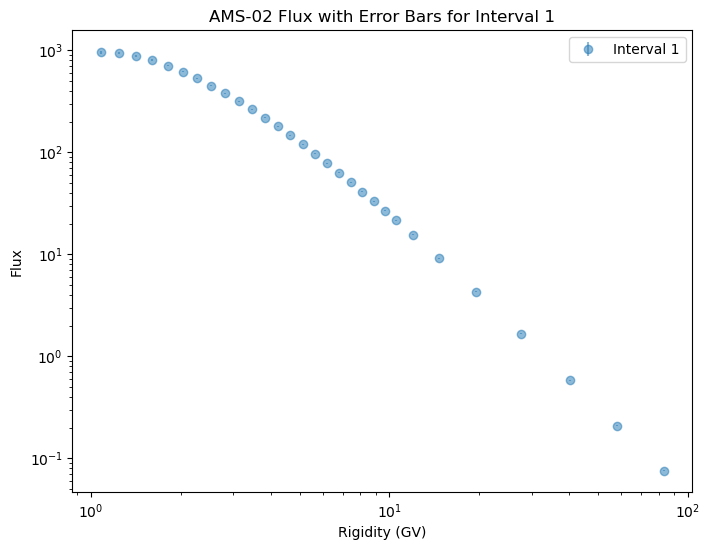

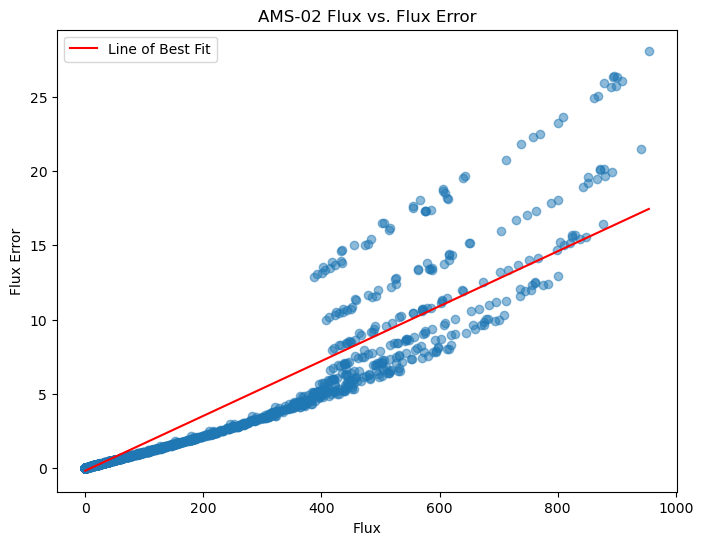

In [5]:
# Load all 132 files, for each rigidity calculate mean and average of the flux error (column 3)
df = index_mcmc_runs(file_version='2023')
path = '/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/GalacticCosmicRays/data/oct2022/'

for idx in range(50): # AMS-02 has the first 50 intervals.
    df_int = df.iloc[idx:idx+1].copy(deep=True)
    interval = df_int.interval.iloc[0]
    polarity = df_int.polarity.iloc[0]
    exp_name = df_int.experiment_name.iloc[0]

    dat_file = f"{path}/{exp_name}/{exp_name}_{interval}.dat"
    dataset_ams = np.loadtxt(dat_file, usecols=(0,1,2,3)) # Rigidity1, Rigidity2, Flux, Error,
    if idx == 0:
        ams_fluxes = np.zeros((len(df), len(dataset_ams)))
        ams_errors = np.zeros((len(df), len(dataset_ams)))
        ams_rigidity_vals = (dataset_ams[:,0] * dataset_ams[:,1]) ** 0.5  # Geometric mean
    ams_fluxes[idx,:] = dataset_ams[:,2]
    ams_errors[idx,:] = dataset_ams[:,3]

ams_mean_errors = np.mean(ams_errors, axis=0)
ams_std_errors = np.std(ams_errors, axis=0)
print("---\nAMS-02 Mean and Std Dev of Flux Errors over all Intervals:")
for r, mean_err, std_err in zip(ams_rigidity_vals, ams_mean_errors, ams_std_errors):
    print(f"Rigidity: {r:.4f} GV, Mean Error: {mean_err:.6e}, Std Error: {std_err:.6e}")

# Plot flux against error for AMS-02
plt.figure(figsize=(8,6))
plt.errorbar(ams_rigidity_vals, ams_fluxes[0,:], yerr=ams_errors[0,:], fmt='o', label='Interval 1', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rigidity (GV)')
plt.ylabel('Flux')
plt.title('AMS-02 Flux with Error Bars for Interval 1')
plt.legend()
plt.show()

# Plot flux against error for AMS-02
plt.figure(figsize=(8,6))
plt.scatter(ams_fluxes, ams_errors, alpha=0.5)
# plt.xscale('log')
# plt.yscale('log')

# Line of best fit
coeffs = np.polyfit(ams_fluxes.flatten(), ams_errors.flatten(), deg=1)
poly_ams = np.poly1d(coeffs)
x_vals = np.linspace(np.min(ams_fluxes), np.max(ams_fluxes), 32)
y_vals = poly_ams(x_vals)
plt.plot(x_vals, y_vals, color='red', label='Line of Best Fit')

plt.xlabel('Flux')
plt.ylabel('Flux Error')
plt.title('AMS-02 Flux vs. Flux Error')
plt.legend()
plt.show()

---
PAMELA Mean and Std Dev of Flux Errors over all Intervals:
Rigidity: 0.4147 GV, Mean Error: 4.479121e+01, Std Error: 2.347838e+01
Rigidity: 0.4447 GV, Mean Error: 5.054721e+01, Std Error: 2.558942e+01
Rigidity: 0.4650 GV, Mean Error: 5.797366e+01, Std Error: 2.725209e+01
Rigidity: 0.4799 GV, Mean Error: 5.738425e+01, Std Error: 3.156812e+01
Rigidity: 0.4999 GV, Mean Error: 5.980590e+01, Std Error: 3.236475e+01
Rigidity: 0.5296 GV, Mean Error: 6.282839e+01, Std Error: 3.496509e+01
Rigidity: 0.5599 GV, Mean Error: 7.075073e+01, Std Error: 3.687140e+01
Rigidity: 0.5799 GV, Mean Error: 7.372689e+01, Std Error: 3.743913e+01
Rigidity: 0.6097 GV, Mean Error: 7.454204e+01, Std Error: 4.016703e+01
Rigidity: 0.6448 GV, Mean Error: 7.909227e+01, Std Error: 4.248430e+01
Rigidity: 0.6699 GV, Mean Error: 8.175383e+01, Std Error: 4.329927e+01
Rigidity: 0.6948 GV, Mean Error: 8.288570e+01, Std Error: 4.549683e+01
Rigidity: 0.7297 GV, Mean Error: 8.779894e+01, Std Error: 4.818664e+01
Rigidity: 0.76

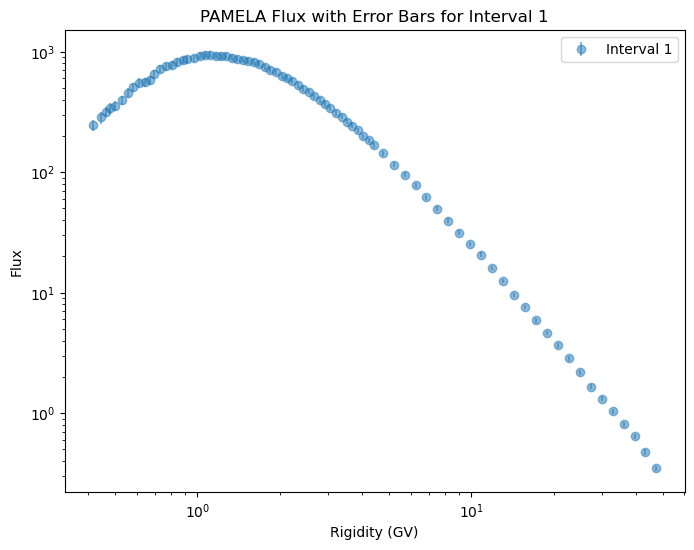

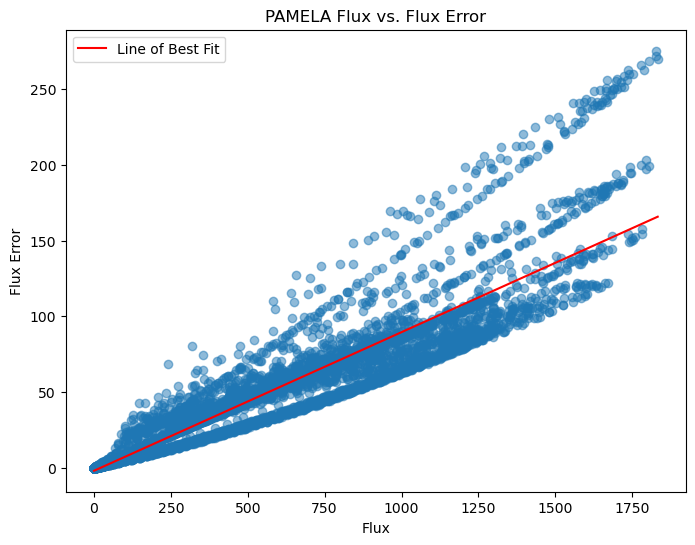

In [6]:
for idx in range(50, 133): # PAMELA is intervals 50-132.
    df_int = df.iloc[idx:idx+1].copy(deep=True)
    interval = df_int.interval.iloc[0]
    polarity = df_int.polarity.iloc[0]
    exp_name = df_int.experiment_name.iloc[0]

    dat_file = f"{path}/{exp_name}/{exp_name}_{interval}.dat"
    dataset_pamela = np.loadtxt(dat_file, usecols=(0,1,2,3)) # Rigidity1, Rigidity2, Flux, Error,
    if idx == 50:
        pamela_fluxes = np.zeros((len(df)-50, len(dataset_pamela)))
        pamela_errors = np.zeros((len(df)-50, len(dataset_pamela)))
        pamela_rigidity_vals = (dataset_pamela[:,0] * dataset_pamela[:,1]) ** 0.5  # Geometric mean
    pamela_fluxes[idx-50,:] = dataset_pamela[:,2]
    pamela_errors[idx-50,:] = dataset_pamela[:,3]
    
pamela_mean_errors = np.mean(pamela_errors, axis=0)
pamela_std_errors = np.std(pamela_errors, axis=0)
print("---\nPAMELA Mean and Std Dev of Flux Errors over all Intervals:")
for r, mean_err, std_err in zip(pamela_rigidity_vals, pamela_mean_errors, pamela_std_errors):
    print(f"Rigidity: {r:.4f} GV, Mean Error: {mean_err:.6e}, Std Error: {std_err:.6e}")

# Plot flux against error for PAMELA
plt.figure(figsize=(8,6))
plt.errorbar(pamela_rigidity_vals, pamela_fluxes[0,:], yerr=pamela_errors[0,:], fmt='o', label='Interval 1', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rigidity (GV)')
plt.ylabel('Flux')
plt.title('PAMELA Flux with Error Bars for Interval 1')
plt.legend()
plt.show()

# Plot flux against error for PAMELA
plt.figure(figsize=(8,6))
plt.scatter(pamela_fluxes, pamela_errors, alpha=0.5)
# plt.xscale('log')
# plt.yscale('log')

# Line of best fit
coeffs = np.polyfit(pamela_fluxes.flatten(), pamela_errors.flatten(), deg=1)
poly_pamela = np.poly1d(coeffs)
x_vals = np.linspace(np.min(pamela_fluxes), np.max(pamela_fluxes), 32)
y_vals = poly_pamela(x_vals)
plt.plot(x_vals, y_vals, color='red', label='Line of Best Fit')

plt.xlabel('Flux')
plt.ylabel('Flux Error')
plt.title('PAMELA Flux vs. Flux Error')
plt.legend()
plt.show()

Create y test .dat file adn test_specified_parameters.csv file

In [7]:
# 8 input parameters for the NN: alpha, cmf, vspoles, cpa, pwr1par, pwr2par, pwr1perr, and pwr2perr.
# features = ['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr', 'vspoles']
h5_file = '/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/shuffled_may2025/neg/test.h5'

# Load test data
with h5py.File(h5_file, 'r') as h5:
    num_test_samples, num_inputs,  = h5['X_minmax'].shape
    _, num_flux,  = h5['Y_log_scaled'].shape
x_test = h5py.File(h5_file, 'r')['X_minmax'][:].reshape(num_test_samples, num_inputs)
y_test = h5py.File(h5_file, 'r')['Y_log_scaled'][:].reshape(num_test_samples, num_flux)

# get alpha, cmf, and vspoles (0, 1, and 7 index)
specified_parameters = x_test[:, [0, 1, 7]]

print(f'specified_parameters shape: {specified_parameters.shape}, x_test shape: {x_test.shape}, y_test shape: {y_test.shape}')
print('---')
print(f'First 10 samples of specified_parameters_unscaled:\n{specified_parameters[:10]}\n')
print(f'First 10 samples of x_test:\n{x_test[:10]}\n')
print(f'First 10 samples of y_test:\n{y_test[:10]}')
print('---')

# Undo scaling and log transforms
# Calculated from positive file, used for both.
Y_LOG_MAX = 8.815241
y_test = y_test * Y_LOG_MAX # Undo max scaling.
y_test = np.exp(y_test) # Undo log transform of target output.

specified_parameters_unscaled = untransform_input(specified_parameters)
x_test_unscaled = untransform_input(x_test)

print(f'specified_parameters_unscaled shape: {specified_parameters_unscaled.shape}, y_test shape: {y_test.shape}')
print('---')
print(f'First 10 samples of specified_parameters_unscaled:\n{specified_parameters_unscaled[:10]}\n')
print(f'First 10 samples of x_test_unscaled sampled params: \n{x_test_unscaled[:, [2, 3, 4, 5, 6]][:10]}\n')
print(f'First 10 samples of x_test_unscaled:\n{x_test_unscaled[:10]}\n')
print(f'First 10 samples of y_test_unscaled:\n{y_test[:10]}')
print('---')

specified_parameters shape: (198766, 3), x_test shape: (198766, 8), y_test shape: (198766, 32)
---
First 10 samples of specified_parameters_unscaled:
[[0.         0.85714287 0.33333334]
 [0.88235295 0.5714286  0.        ]
 [0.3529412  0.5714286  0.6666667 ]
 [0.29411766 0.5714286  0.6666667 ]
 [0.         1.         0.        ]
 [0.         0.5714286  1.        ]
 [0.29411766 0.85714287 1.        ]
 [0.47058824 0.5        0.        ]
 [0.         0.2857143  0.        ]
 [0.29411766 0.71428573 0.6666667 ]]

First 10 samples of x_test:
[[0.         0.85714287 0.37662336 0.69230765 0.         0.
  0.4736842  0.33333334]
 [0.88235295 0.5714286  1.         0.46153846 0.2307692  0.
  0.3157895  0.        ]
 [0.3529412  0.5714286  0.06493507 0.46153846 0.2307692  0.15789473
  0.6842106  0.6666667 ]
 [0.29411766 0.5714286  1.         0.2307692  0.46153846 0.15789473
  0.15789473 0.6666667 ]
 [0.         1.         0.         0.69230765 0.46153846 0.6842106
  0.4736842  0.        ]
 [0.        

In [13]:
# y_test is 32 rigidity values evenly distributed in log space between 0.2 and 200 GV
# Need to create a .dat version of y_test with 3 columns: Rigidity1, Rigidity2, Flux
rigidity_list = np.logspace(np.log10(0.2), np.log10(200), 33)
print(f'Rigidity list: {rigidity_list}')
r1 = rigidity_list[:-1]
r2 = rigidity_list[1:]
print(len(r1), len(r2), len(y_test[0]))  # Should both be 31
print(r1)
print(r2)
print(y_test[2][:])

# Create .dat file
for i in range(0, 111): #len(y_test)):
    output_dat_file = f'/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/shuffled_may2025/neg/dat_files_pamela_sampled/test_neg_r1r2flux_sample{i}.dat'
    with open(output_dat_file, 'w') as f:
        for j in range(len(r1)):
            # Find rigidity in AMS or PAMELA that is most similar, then use either the poly_ams or poly_pamela to estimate error given flux
            # similar_rigidity = (r1[j] * r2[j]) ** 0.5  # Geometric mean
            # dis_ams = np.abs(ams_rigidity_vals - similar_rigidity)
            # dis_pamela = np.abs(pamela_rigidity_vals - similar_rigidity)
            # idx_ams = np.argmin(dis_ams)
            # idx_pamela = np.argmin(dis_pamela)

            # Calculate error using PAMELA polynomial fit, since PAMELA errors are generally larger
            curr_flux = y_test[i][j]
            # error = poly_ams(curr_flux)
            error = poly_pamela(curr_flux)

            if error < 0:
                error = 0.05 * curr_flux  # Set a minimum error of 5% if polynomial fit gives negative error
                print(f'Warning: Negative error estimated from polynomial fit for flux {curr_flux:.6e}. Using 5% of flux ({error:.6e}) as error instead.')

            # resample flux value from normal distribution with mean=curr_flux and std=unc
            sampled_flux = np.random.normal(loc=curr_flux, scale=error)
            # sampled_flux = curr_flux

            # Only print for first 10 samples
            print(f'Rigidity: {r1[j]:.4f}-{r2[j]:.4f} GV, Flux: {curr_flux:.6e}, Estimated Error: {error:.6e}, Sampled Flux: {sampled_flux:.6e}')

            f.write(f'{r1[j]} {r2[j]} {sampled_flux} {error}\n')

Rigidity list: [2.00000000e-01 2.48187552e-01 3.07985305e-01 3.82190595e-01
 4.74274741e-01 5.88545435e-01 7.30348255e-01 9.06316728e-01
 1.12468265e+00 1.39566117e+00 1.73192865e+00 2.14921566e+00
 2.66704286e+00 3.30963420e+00 4.10705005e+00 5.09659350e+00
 6.32455532e+00 7.84837952e+00 9.73935050e+00 1.20859278e+01
 1.49978842e+01 1.86114408e+01 2.30956397e+01 2.86602514e+01
 3.55655882e+01 4.41346814e+01 5.47683927e+01 6.79641666e+01
 8.43393007e+01 1.04659823e+02 1.29876326e+02 1.61168438e+02
 2.00000000e+02]
32 32 32
[  0.2          0.24818755   0.30798531   0.38219059   0.47427474
   0.58854544   0.73034825   0.90631673   1.12468265   1.39566117
   1.73192865   2.14921566   2.66704286   3.3096342    4.10705005
   5.0965935    6.32455532   7.84837952   9.7393505   12.0859278
  14.99788419  18.61144082  23.09563969  28.6602514   35.5655882
  44.13468138  54.76839269  67.96416658  84.33930069 104.65982294
 129.87632632 161.16843755]
[  0.24818755   0.30798531   0.38219059   0.47427

In [42]:
# Create .csv with specified_parameters_unscaled
output_csv_file = '/home/linneamw/sadow_koastore/personal/linneamw/research/gcr/data/shuffled_may2025/neg/test_neg_specparams.csv'
import pandas as pd
df = pd.DataFrame(specified_parameters_unscaled, columns=PARAMETERS_SPECIFIED)
print(df.head())
df.to_csv(output_csv_file, index=False)

       alpha  cmf     vspoles
0   0.000000  8.5  500.000003
1  75.000001  6.5  400.000000
2  30.000001  6.5  600.000006
3  25.000001  6.5  600.000006
4   0.000000  9.5  400.000000


In [43]:
specified_parameters = pd.read_csv(output_csv_file).values
print(f'specified_parameters from csv: {specified_parameters[0]}')
print(f'specified_parameters from csv: {specified_parameters[:5]}')

specified_parameters from csv: [  0.           8.50000006 500.00000298]
specified_parameters from csv: [[  0.           8.50000006 500.00000298]
 [ 75.0000006    6.50000018 400.        ]
 [ 30.00000075   6.50000018 600.00000596]
 [ 25.00000104   6.50000018 600.00000596]
 [  0.           9.5        400.        ]]


In [49]:
dataset_ams = np.loadtxt(output_dat_file, usecols=(0,1,2,3)) # Rigidity1, Rigidity2, Flux
print(dataset_ams[:, :])

[[2.00000000e-01 2.48187552e-01 4.10715387e+02 3.78129860e+01]
 [2.48187552e-01 3.07985305e-01 4.09364557e+02 3.88534328e+01]
 [3.07985305e-01 3.82190595e-01 5.09213262e+02 4.09984841e+01]
 [3.82190595e-01 4.74274741e-01 4.84690505e+02 4.43790331e+01]
 [4.74274741e-01 5.88545435e-01 5.21905717e+02 5.04573249e+01]
 [5.88545435e-01 7.30348255e-01 6.13233410e+02 5.84977830e+01]
 [7.30348255e-01 9.06316728e-01 7.91261412e+02 6.89096105e+01]
 [9.06316728e-01 1.12468265e+00 9.29320268e+02 8.38637023e+01]
 [1.12468265e+00 1.39566117e+00 9.81382649e+02 1.02294708e+02]
 [1.39566117e+00 1.73192865e+00 1.32727156e+03 1.24137923e+02]
 [1.73192865e+00 2.14921566e+00 1.89781928e+03 1.50569606e+02]
 [2.14921566e+00 2.66704286e+00 1.98992565e+03 1.77072426e+02]
 [2.66704286e+00 3.30963420e+00 2.42891582e+03 1.99332580e+02]
 [3.30963420e+00 4.10705005e+00 2.45724976e+03 2.12292404e+02]
 [4.10705005e+00 5.09659350e+00 2.10227591e+03 2.09068996e+02]
 [5.09659350e+00 6.32455532e+00 2.40890413e+03 1.886705